In [58]:
import numpy as np
from tqdm import trange

def bartlett_priestley_kernel(u, h):
    return np.maximum((1/h) * (3/4) * (1- np.power(u / h, 2)), 0)

def gaussian_kernel(u, h):
    return (1/h) * (1 / np.sqrt(2*np.pi)) * np.exp((-1/2)*np.power(u / h, 2))

def smoothed_estimate(y, kernel_function, h):
    """ 
        This function implements a smoothed average estimator, using the kernel_function for smoothing.
        See https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=4286562 for the formula 

        Arguments :
            y : 1D np-array of the shape NxP
            kernel_function : Real-valued kernel function 

        Returns :
            m : Smoothed estimate of y        
    """
    N = y.shape[0]
    m = np.zeros_like(y)
    for i in range(N): # TODO Optimize
        x_i = np.arange(N)/N 
        kernel = kernel_function(i/N - x_i, h)
        m[i] = np.mean(kernel*y)
    return m

def calculate_Tn(m1, m2, h):
    return np.sqrt(h) * np.sum(np.square(m1-m2))

def get_wild_residual(epsilon_hat):
    """ 
        PLEASE INPUT VECTOR
    """
    p = np.random.random_sample(epsilon_hat.shape[0])
    gamma = (5 + np.sqrt(5)) / 10
    mask = p < gamma
    a = ((1-np.sqrt(5)) / 2) * epsilon_hat
    b = ((1+np.sqrt(5)) / 2) * epsilon_hat
    b[mask] = a[mask]
    return b

def get_wild_residual_normal(epsilon_hat):
    """ 
        PLEASE INPUT VECTOR
    """
    V_i = np.random.standard_normal(epsilon_hat.shape[0])
    return ((1/np.sqrt(2))*V_i + (1/2)*(np.square(V_i)-1))*epsilon_hat

def generate_synthetic_data(m1, m2, sigma):
    """ 
        All inputs should be 1d np arrays of the same shape # TODO Try other distributions
    """
    y1 = m1 + np.random.standard_normal(m1.shape[0]) * sigma
    y2 = m2+ np.random.standard_normal(m1.shape[0]) * sigma
    
    return y1, y2

def wild_bootstrap(y1, y2, kernel_function, h, g, residual_function, B, alpha):
    """ 
        returns true if H0 is rejected
    """
    m1 = smoothed_estimate(y1, kernel_function, h)
    m2 = smoothed_estimate(y2, kernel_function, h)

    Tn = calculate_Tn(m1, m2, h)

    epsilon_hat_1 = y1 - m1
    epsilon_hat_2 = y2 - m2

    Tn_star = np.zeros(B)

    for i in trange(B): # TODO Parllelize
        wild_epsilon_1 = residual_function(epsilon_hat_1)
        wild_epsilon_2 = residual_function(epsilon_hat_2)

        m1_g = smoothed_estimate(y1, kernel_function, g)

        y1_star = m1_g + wild_epsilon_1
        y2_star = m1_g + wild_epsilon_2

        m1_star = smoothed_estimate(y1_star, kernel_function, h)
        m2_star = smoothed_estimate(y2_star, kernel_function, h)

        Tn_star[i] = calculate_Tn(m1_star, m2_star, h)

    q = 1-alpha
    c_alpha_star = np.quantile(Tn_star, q)

    rejected_bool = Tn > c_alpha_star

    print("The Hypothesis H0 was %srejected" %("" if rejected_bool else "not"))
    print("c_alpha_star is %.4f"%c_alpha_star)

    return Tn > c_alpha_star, c_alpha_star

In [62]:
N = 500
x = np.arange(N)/N
m1 = np.sin(np.pi*2*x)
m2 = np.sin(np.pi*2*x) + np.exp((-800)*np.power(x-0.5, 2))
sigma = 0.7 - 1.4*np.square(x-0.5)

y1, y2 = generate_synthetic_data(m1, m2, sigma)
rejected_bool, c_alpha_star = wild_bootstrap(y1, y1, bartlett_priestley_kernel, h=0.02, g=0.03, residual_function=get_wild_residual, B=1000, alpha=0.95)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:42<00:00, 23.48it/s]

The Hypothesis H0 was not rejected
c_alpha_star is 1.7658


In [53]:
epsilon_hat = np.random.random_sample(10)
x_all = np.zeros((1000000, 10))
for i in range(1000000):
    x_all[i, :] = get_wild_residual_normal(epsilon_hat)
print(np.square(epsilon_hat))
print(np.power(epsilon_hat, 3))
print(np.mean(x_all, axis=0))
print(np.mean(np.square(x_all), axis=0))
print(np.mean(np.power(x_all, 3), axis=0))

[0.13577302 0.61535688 0.05483888 0.00195931 0.98696543 0.59731777
 0.30678458 0.43892964 0.12777103 0.00440108]
[5.00288125e-02 4.82714778e-01 1.28420060e-02 8.67273686e-05
 9.80511992e-01 4.61645014e-01 1.69922268e-01 2.90798633e-01
 4.56718471e-02 2.91970797e-04]
[ 8.46502879e-05 -1.99748769e-04  4.07817114e-04  8.72737879e-05
  1.10512251e-03  7.09511258e-04 -2.84110485e-04 -3.37913755e-04
 -3.63928846e-04 -5.34928480e-05]
[0.1362052  0.61386156 0.05504776 0.00196538 0.98445131 0.59749675
 0.30567715 0.43817948 0.12760129 0.0043904 ]
[1.25257266e-01 1.20002370e+00 3.21806678e-02 2.17707046e-04
 2.41981002e+00 1.15145347e+00 4.20882342e-01 7.22787293e-01
 1.14017265e-01 7.25003785e-04]


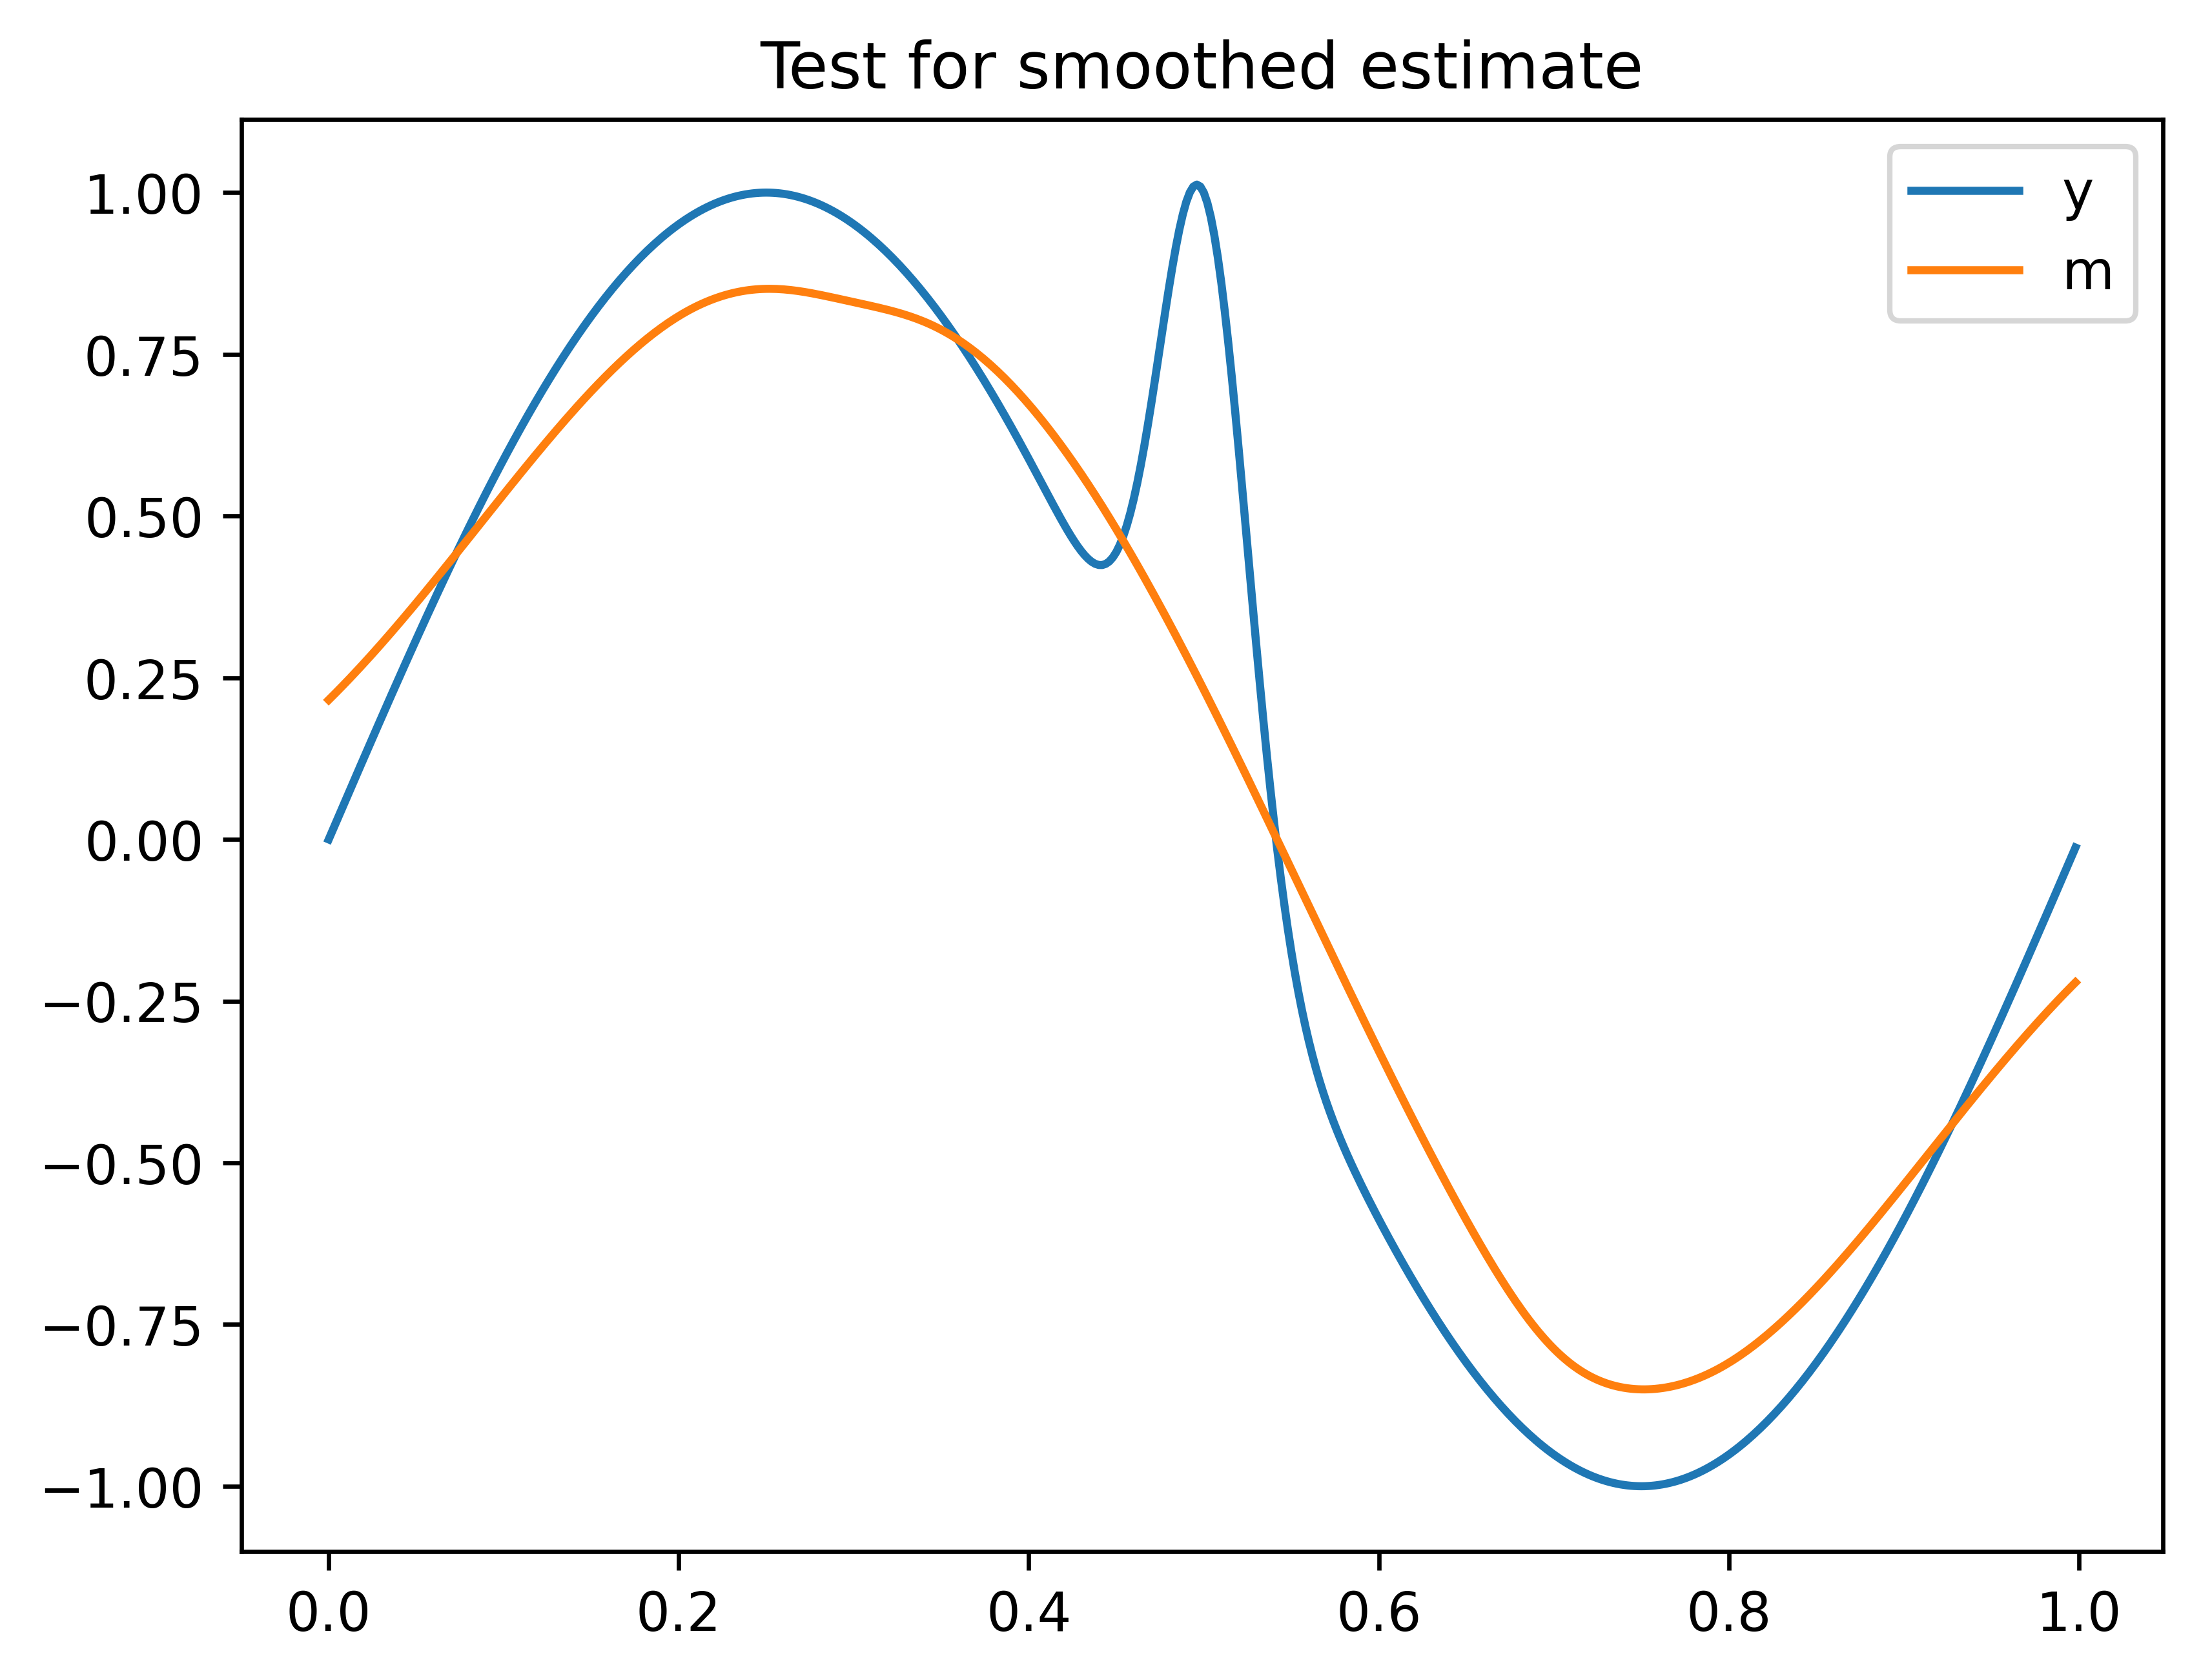

In [34]:
import matplotlib.pyplot as plt 
N = 500
x = np.arange(N)/N
y = np.sin(np.pi * 2* x) + np.exp((-800)*np.power(x-0.5, 2))
m = smoothed_estimate(y, bartlett_priestley_kernel, h=0.2)

plt.figure(dpi=600)
plt.plot(x, y)
plt.plot(x, m)
plt.title("Test for smoothed estimate")
plt.legend(["y", "m"])
plt.show()